In [2]:
import numpy as np
import scipy as sp
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import sklearn
import scipy.stats as stats
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import mahalanobis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from scipy.linalg import fractional_matrix_power
%matplotlib inline
import matplotlib
font = {'variant' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

## Вспомогательные функции

In [159]:
def KL_div_norm(dist1, dist2):
    mean1 = np.mean(dist1, axis=0)
    cov1 = np.cov(dist1, rowvar=0)
    mean2 = np.mean(dist2, axis=0)
    cov2 = np.cov(dist2, rowvar=0)
    div = 0.5 * (np.trace(np.dot(np.linalg.inv(cov2), cov1)) + np.dot(np.dot((mean2 - mean1), np.linalg.inv(cov2)),(mean2 - mean1)) - cov2.shape[0] + np.log(np.linalg.det(cov2) / np.linalg.det(cov1)))
    return div

In [173]:
def get_param_distr(X, y, n, count=50):
    l = X.shape[0]
    C = 1
    distr=[]
    losses = 0 
    clf0 = LogisticRegression(C=C, random_state=0, solver='lbfgs')
    clf0.fit(X,y)
    for i in range(0,count):
        choice = np.random.choice(range(0,l), n)
        clf = LogisticRegression(C=C, random_state=0, solver='lbfgs')
        while not((0 in y[choice]) and (1 in y[choice])):
            choice = np.random.choice(range(0,l), n)
        clf.fit(X[choice],y[choice])
        coef = clf.coef_
        distr.append(coef[0])
        losses += sklearn.metrics.log_loss(y, clf.predict_proba(X))
    return np.asarray(distr), losses

## Обработка датасетов
### Скользящий контроль

In [133]:
g = open("/home/alea/2018-Project-16/Evgin2018Project16/heart.csv")

data_h = []
for line in g:
    data_h.append(list(map(float, line.replace(";"," ").replace("\n","").split())))
data_h = np.asarray(data_h)
data_h = data_h[:,[0,3,4,7,9,11,13]]
np.random.shuffle(data_h)
X_h = data_h[:,:-1]
X_h = preprocessing.scale(X_h[:,:-1])
y_h = data_h[:,-1]-np.ones(data_h[:,-1].shape[0])

In [134]:
# Randomly split data to train|test parts
seed = 0 # seed for random generation (to get same split again and again)
X, X_t, y, y_t = train_test_split(X_h, y_h, test_size=10, random_state=seed)
print('Train size: {}\nTest size: {}'.format(len(X), len(X_t)))

Train size: 293
Test size: 10


# Задания E, H, M

## Эксперимент

Точность (доля правильно предсказанных результатов на тестовой выборке):

$\sum_{i=0}^k \mathfrak{I}(y_{test} = y_{pred})$

где $k$ - размер тестовой выборки, $\mathfrak{I}$ - индикаторная функция

In [151]:
min_size = 10  # heuristiucs num
max_size = y.shape[0]  # train dataset size
k = y_t.shape[0]  # test dataset size
accuracy = []
for n in range(min_size, max_size):
    clf = LogisticRegression(random_state=random_state,
                             solver='lbfgs')
    clf.fit(X[:n],y[:n])
    y_pred = clf.predict(X[:n])
    y_pred_t = clf.predict(X_t[:k])
    accuracy.append(np.sum(y_pred_t[:k] == y_t[:k]) / k)

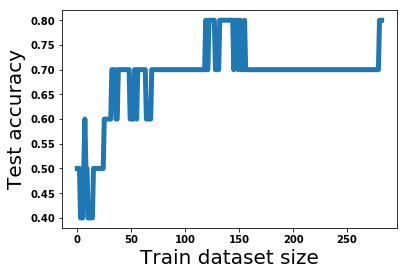

In [153]:
plt.plot(accuracy, lw = 5)
plt.xlabel('Train dataset size', fontsize=20)
plt.ylabel('Test accuracy', fontsize=20)
plt.show()

Точность модели меняется хаотично в зависимости от размера тренировочной выборки

## Статистические тесты

### Анализ дисперсии параметров и функции ошибки

In [174]:
distributions = []
losses = []
start = 24
stop = 100
volume = 200
for n in range(start, volume - 1):
    dis, loss = get_param_distr(X[:n], y[:n], n - n // 4, count = 300)
    distributions.append(dis)
    losses.append(loss)

KeyboardInterrupt: 

In [175]:
mlist = [(len(distributions)//4)*i for i in range(1,5)]

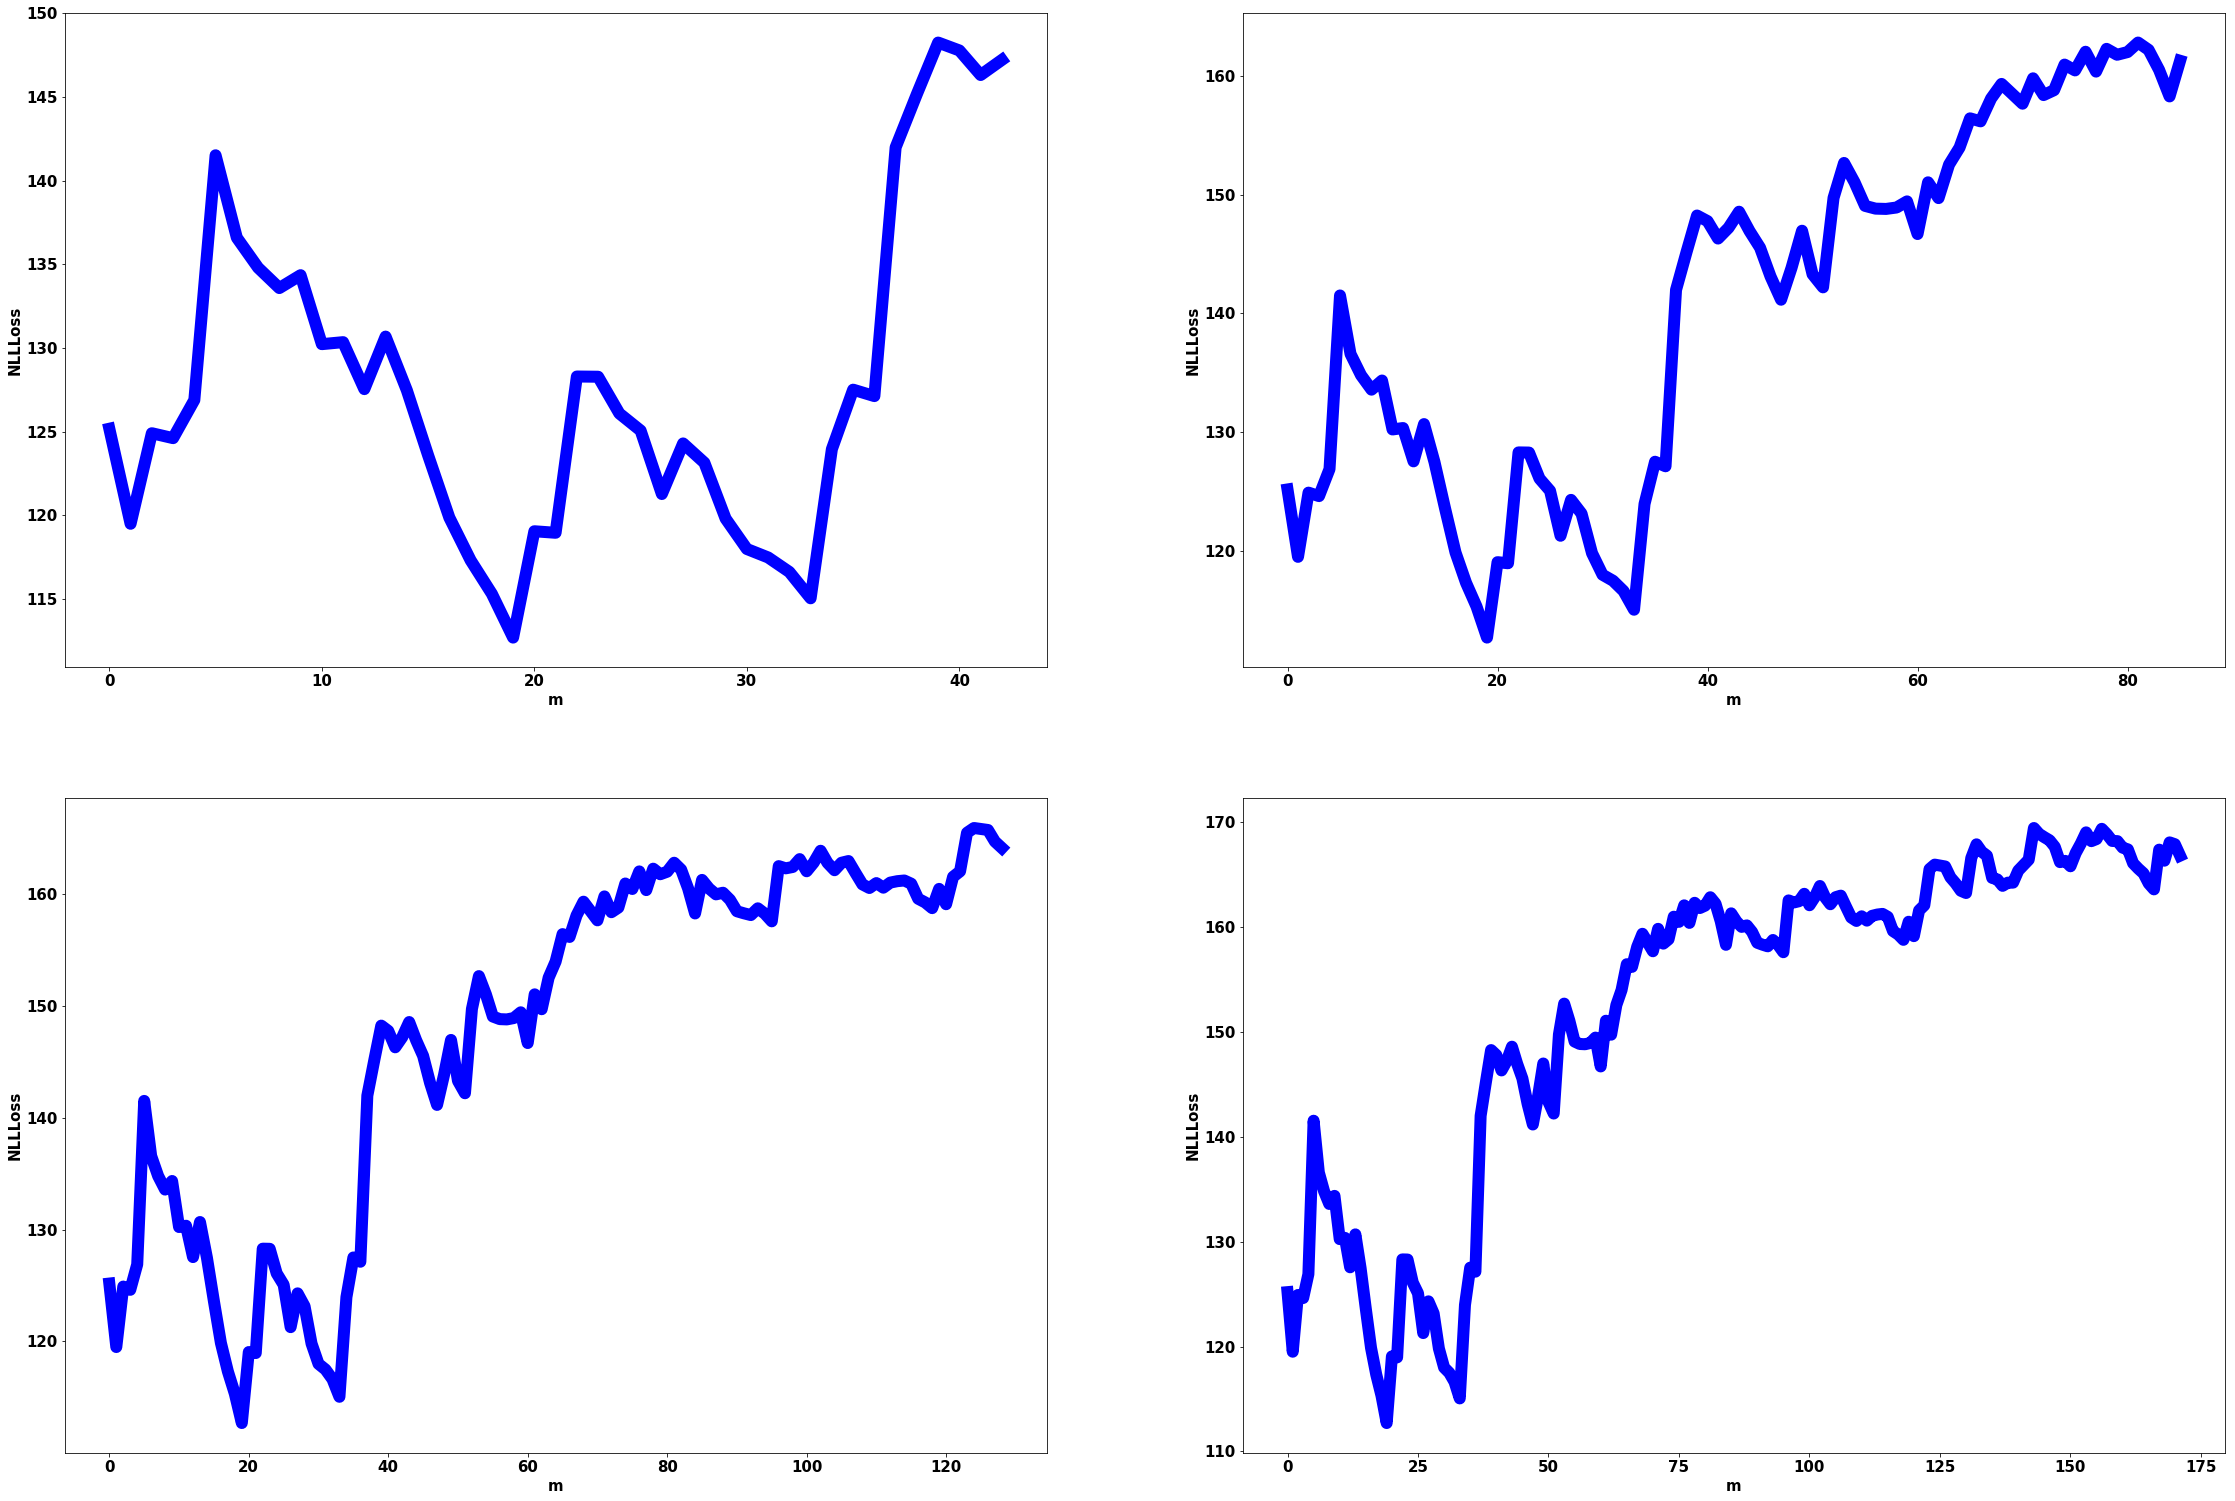

In [137]:
k = 0
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0,right =5,bottom = 0, top=5)

for m in mlist:
    dev=[]
    ax = axs[k//2, k%2]
    euclid = []
    k = k+1
    ax.set_autoscale_on(True)
    ax.set_ylabel('NLLLoss',fontdict=font)
    ax.set_xlabel('m',fontdict=font)
    ax.plot(losses[:m],lw=12, color='blue')  
plt.show()

Начиная с некоторого размера выборки потери выходят на константный уровень

### Евклидово расстояние

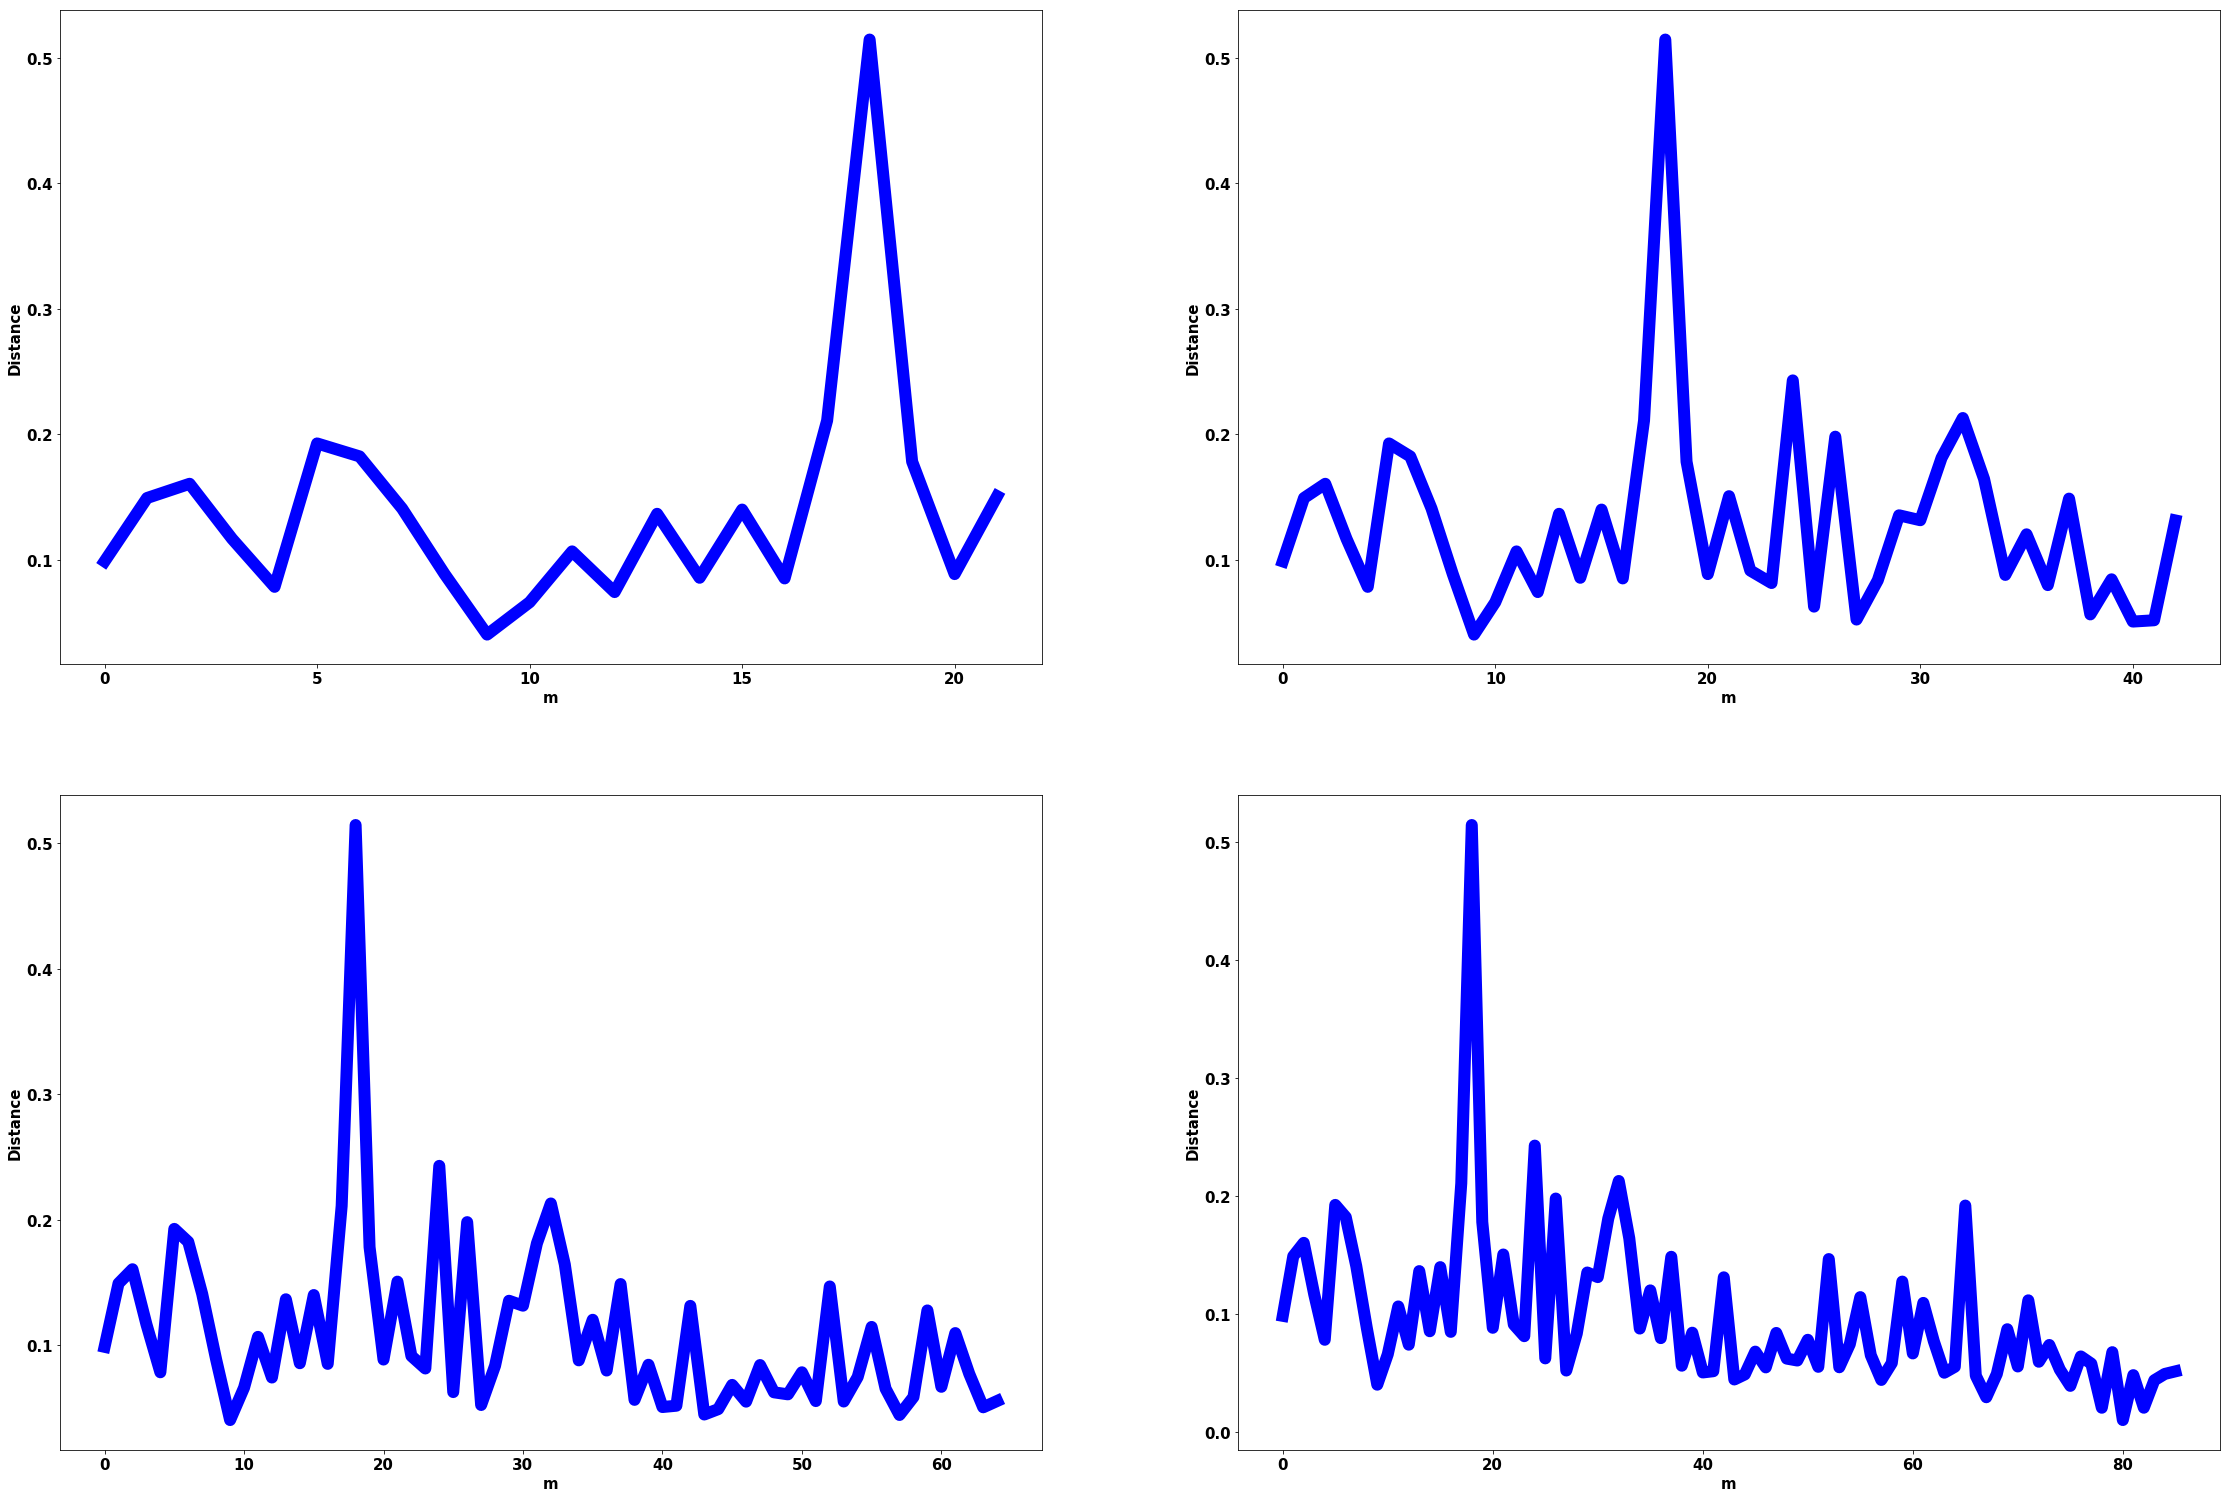

In [138]:
k = 0
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0,right =5,bottom = 0, top=5)

for m in mlist:
    dev=[]
    ax = axs[k//2, k%2]
    euclid = []
    for i in range(0,m,2):
        w1 = np.mean(distributions[i],0)
        w2 = np.mean(distributions[i+1],0)
        euclid.append(np.linalg.norm(w1-w2))
    k = k+1
    ax.set_autoscale_on(True)
    ax.set_ylabel('Distance',fontdict=font)
    ax.set_xlabel('m',fontdict=font)
    ax.plot(euclid[:m],lw=12, color='blue')  
plt.show()

### След матрицы ковариации

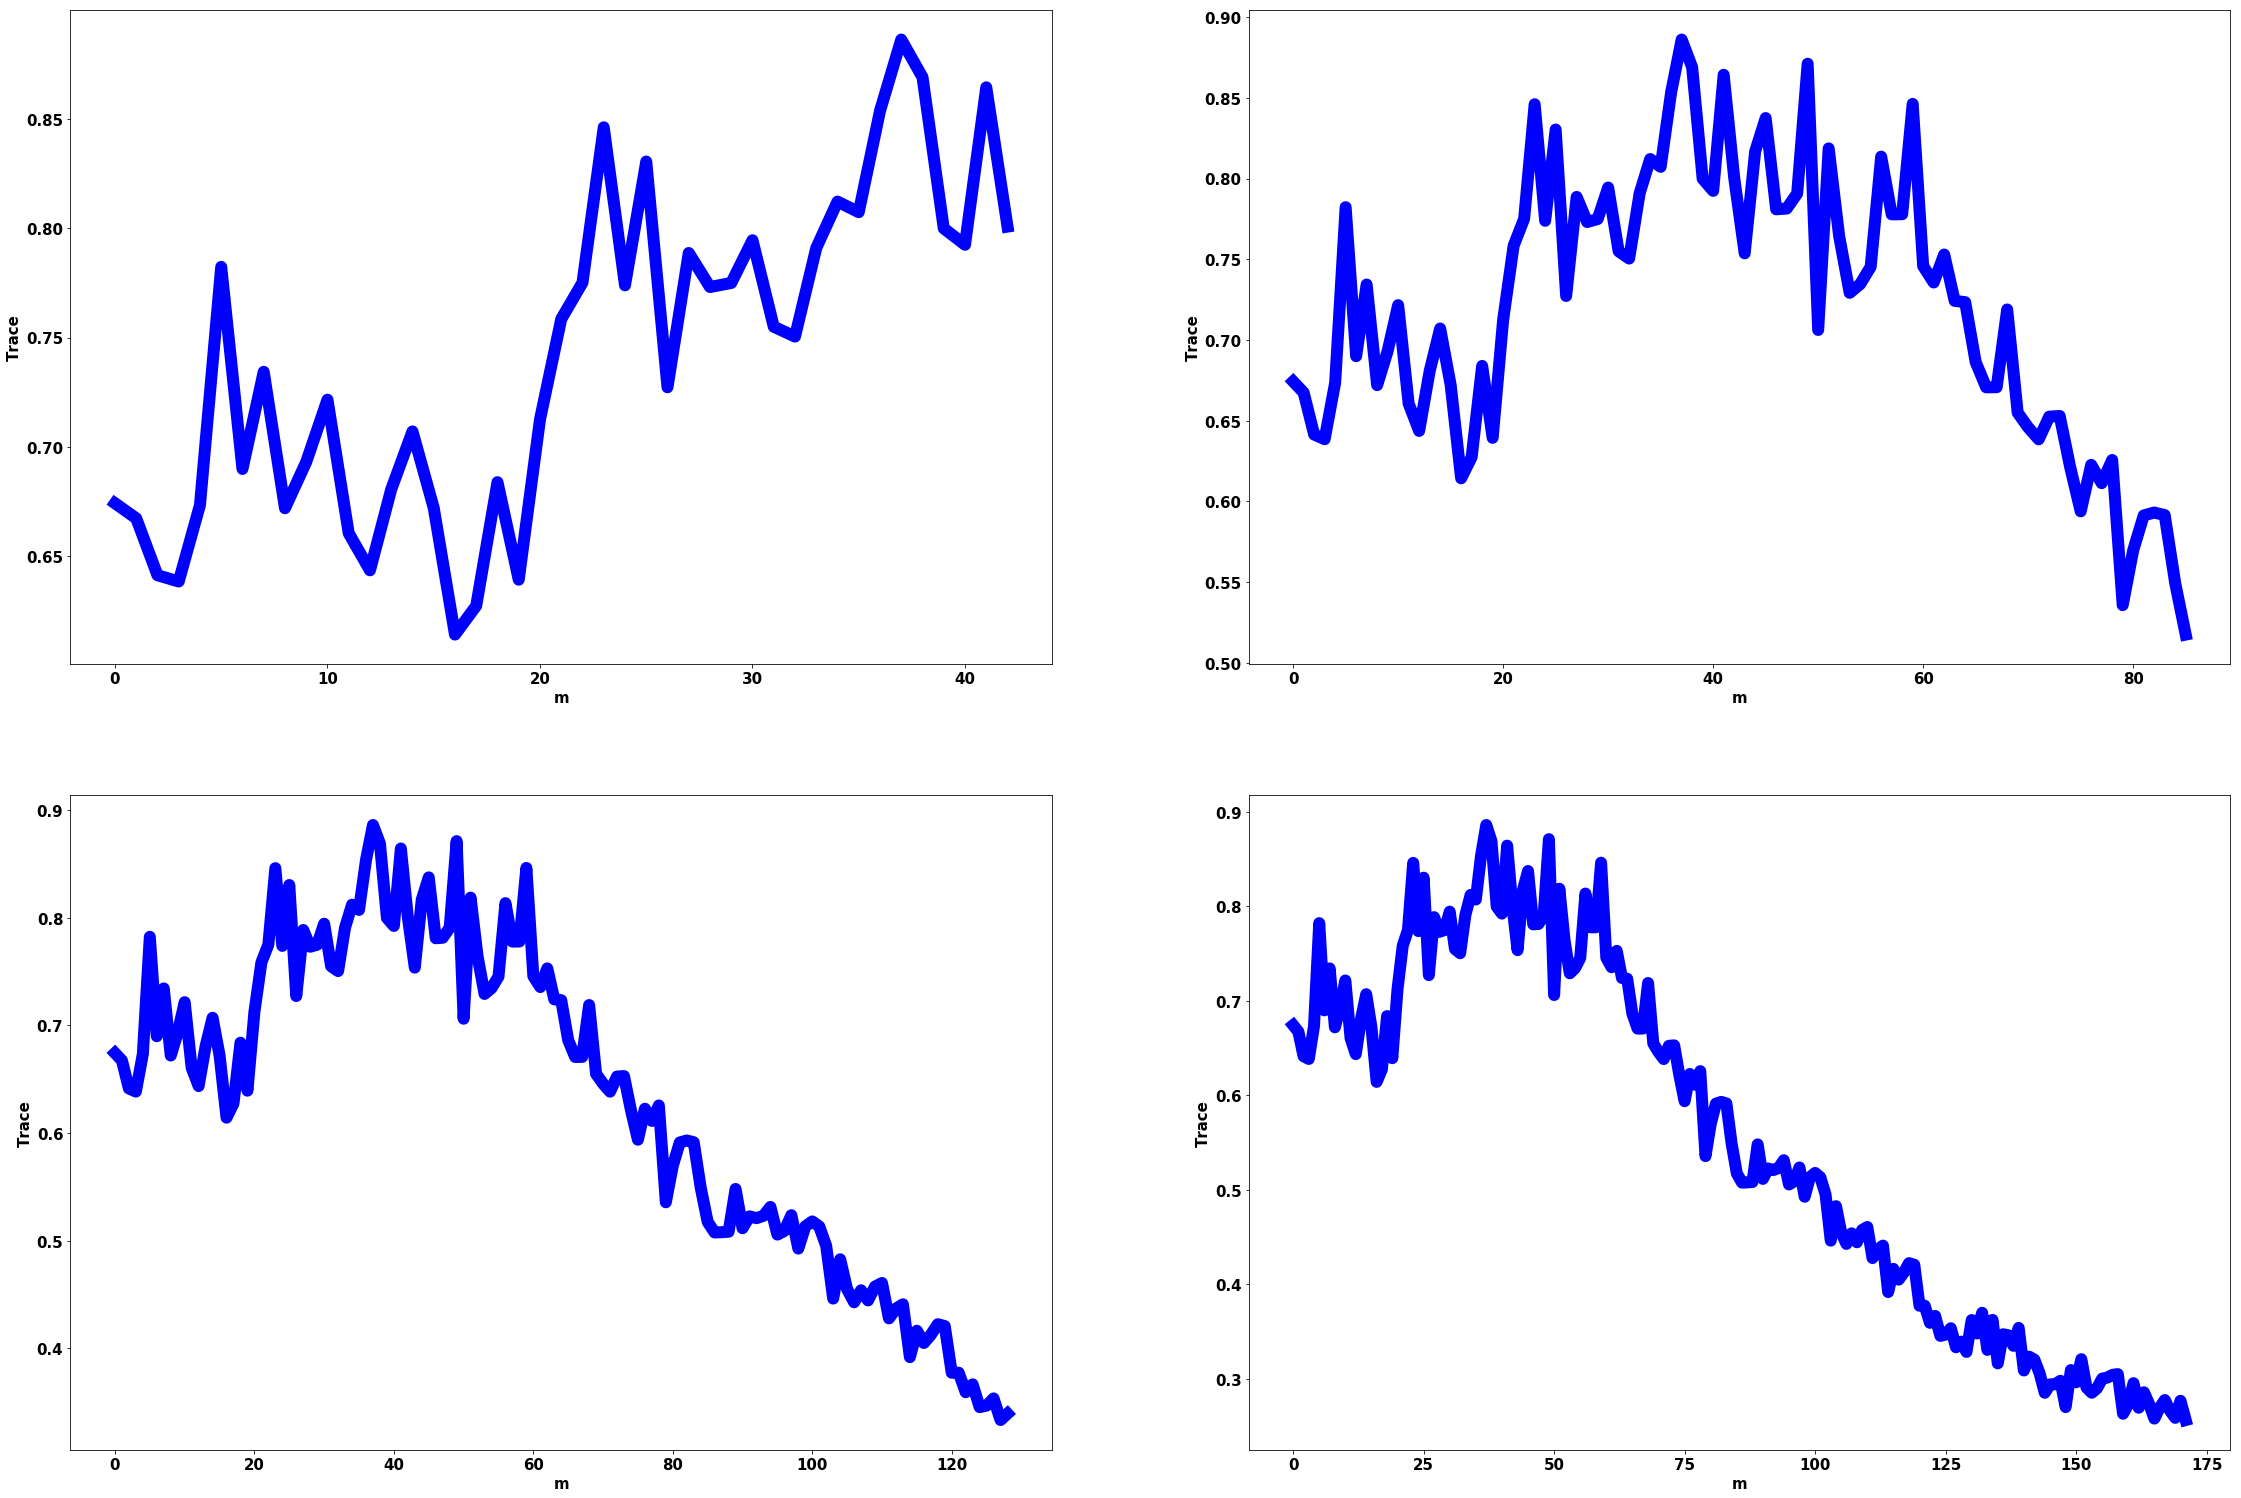

In [139]:
k = 0
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0,right =5,bottom = 0, top=5)

for m in mlist:
    dev=[]
    ax = axs[k//2, k%2]
    for i in range(0,m):
        dev.append(np.trace(np.cov(distributions[i],rowvar=0)))
    k = k+1
    ax.set_autoscale_on(True)
    ax.set_ylabel('Trace',fontdict=font)
    ax.set_xlabel('m',fontdict=font)
    ax.plot(dev[:m],lw=12, color='blue')  
plt.show()

Распределение становится насыщенным, когда график матрицы ковареации выходит на плато

## Проекция вектора параметров

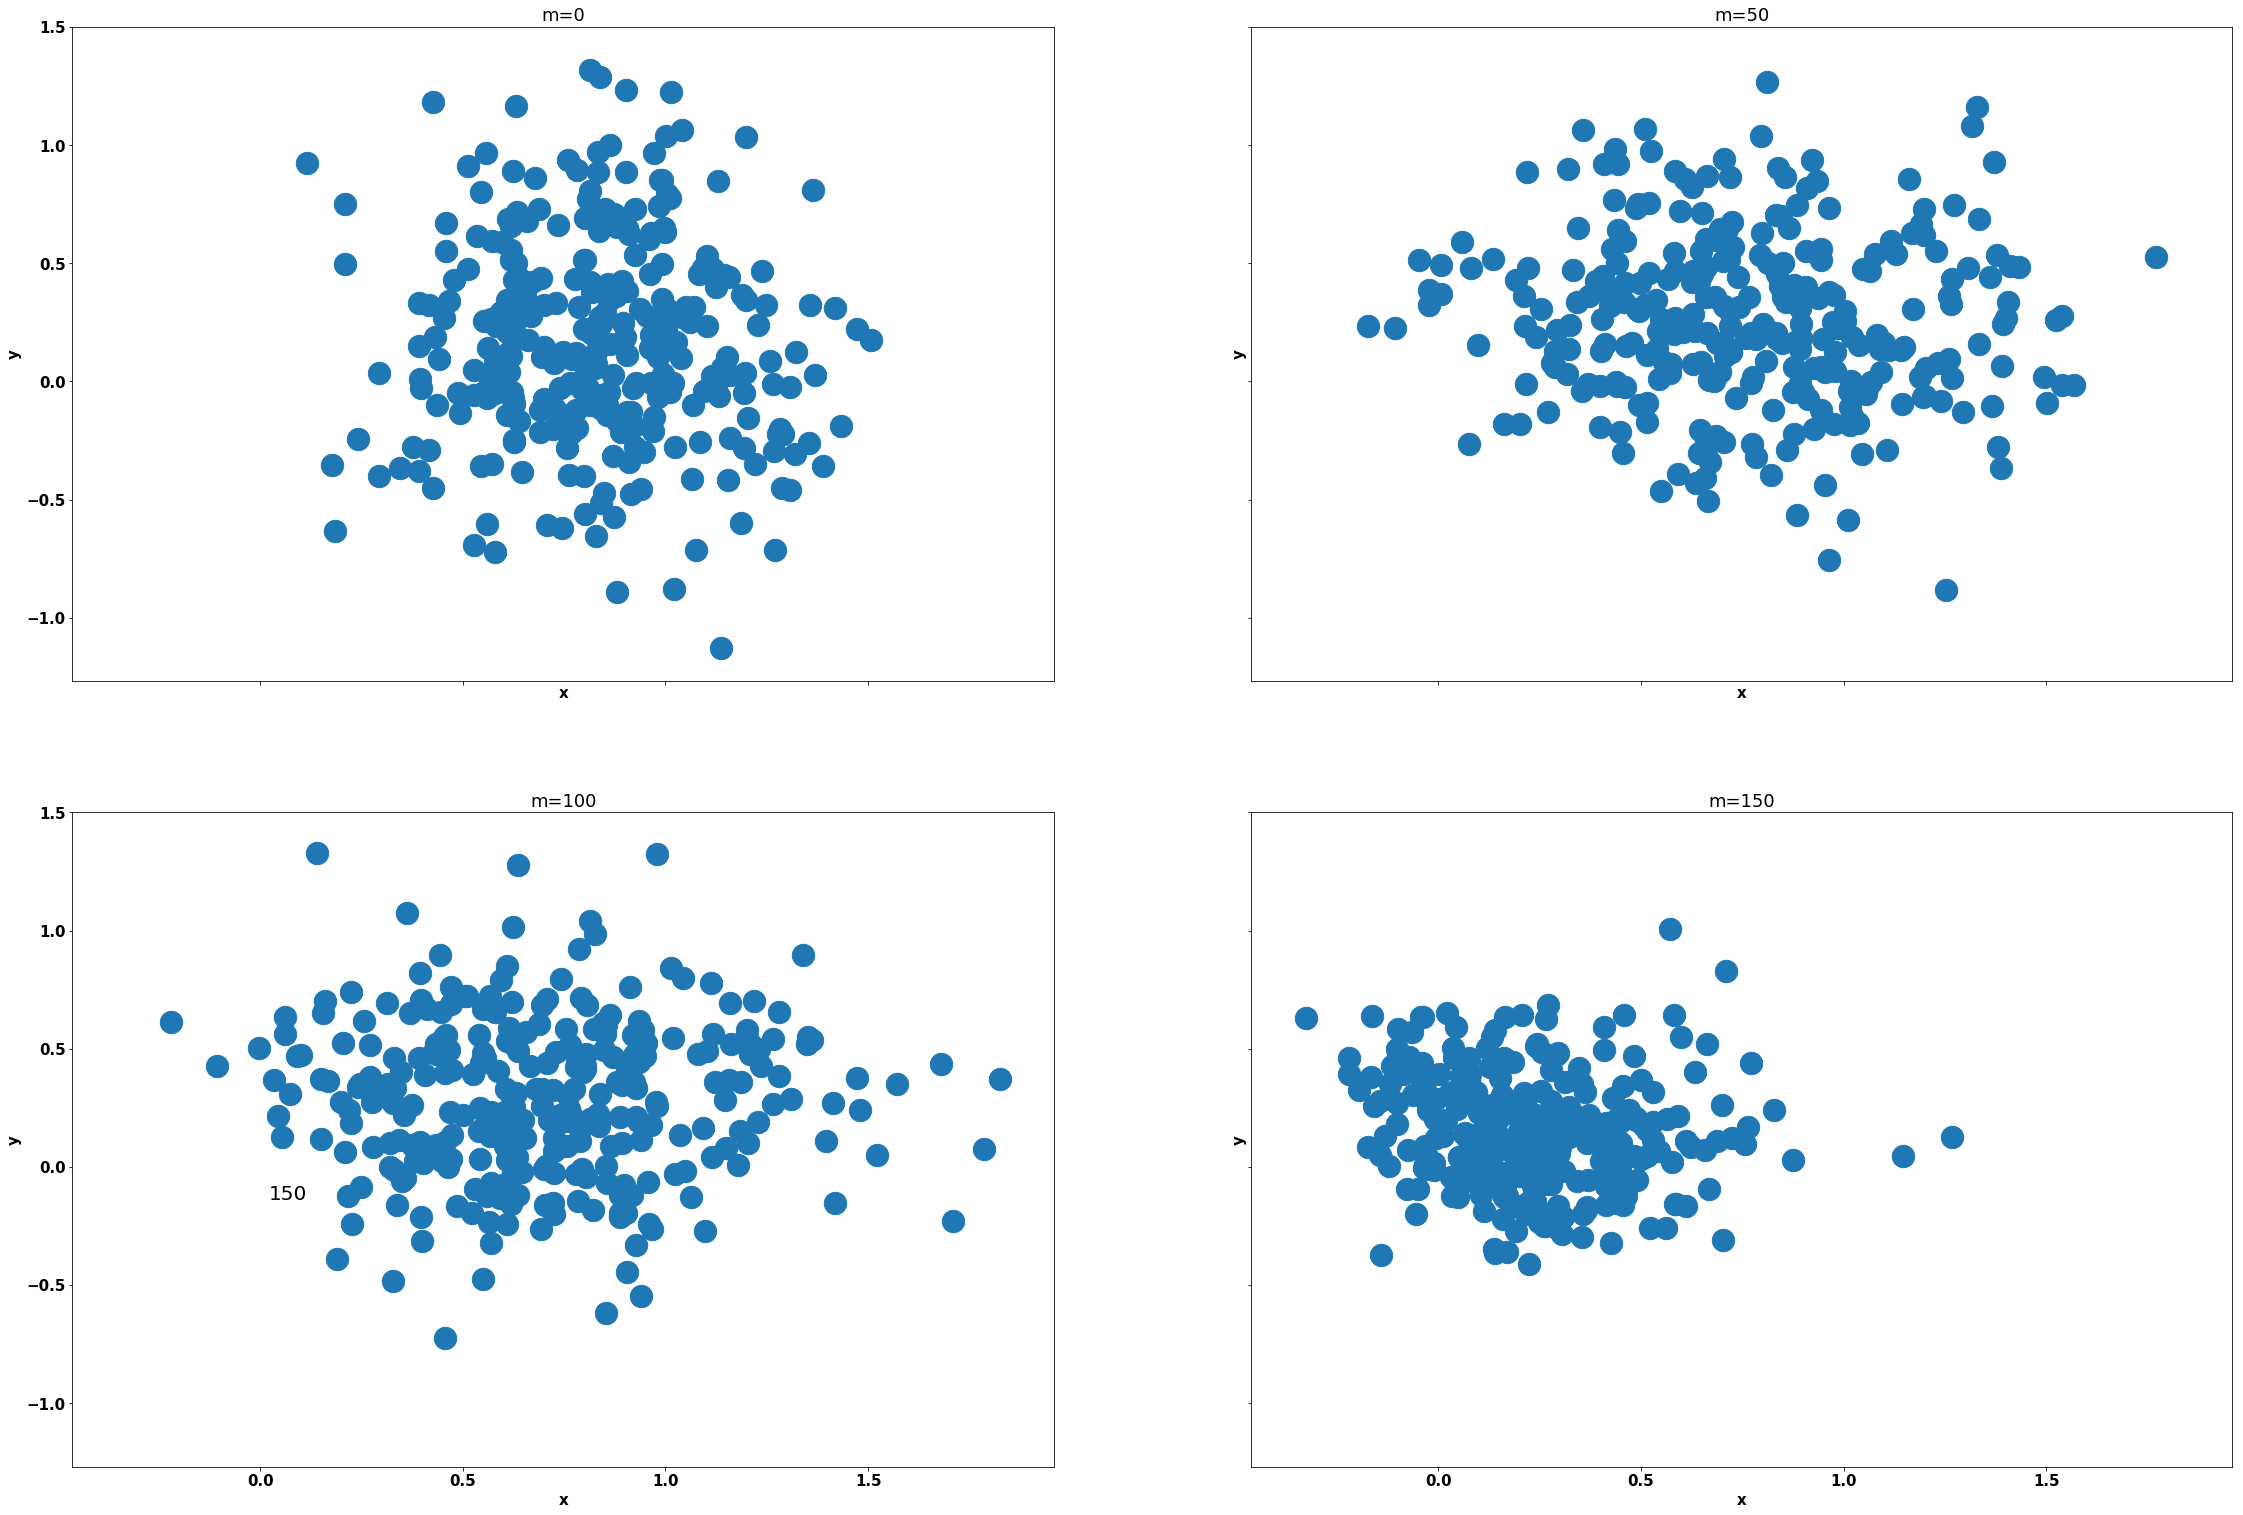

In [141]:
k = 0
fig, axs = plt.subplots(2, 2,sharex=True,sharey=True)
fig.subplots_adjust(left=0,right =5,bottom = 0, top=5)
for i in range(0,187,50):
    fig.suptitle(''+str(i), fontsize=20)
    ax = axs[k//2, k%2]
    k = k+1
    ax.set_autoscale_on(True)
    ax.set_title("m="+str(i))
    ax.set_ylabel('y',fontdict=font)
    ax.set_xlabel('x',fontdict=font)
    ax.scatter(distributions[i][:,2],distributions[i][:,0],500)
plt.show()

### Видно, что при увелечении количества объектов, дисперсия уменьшается

## Гистограмма распределений

In [176]:
plt.hist(distributions[70][:,1])

IndexError: list index out of range

## Проекция среднего вектора

In [143]:
means = []
for i in range(0,volume-start-3,1):
    means.append(np.mean(distributions[i],axis=0))
means = np.asarray(means)

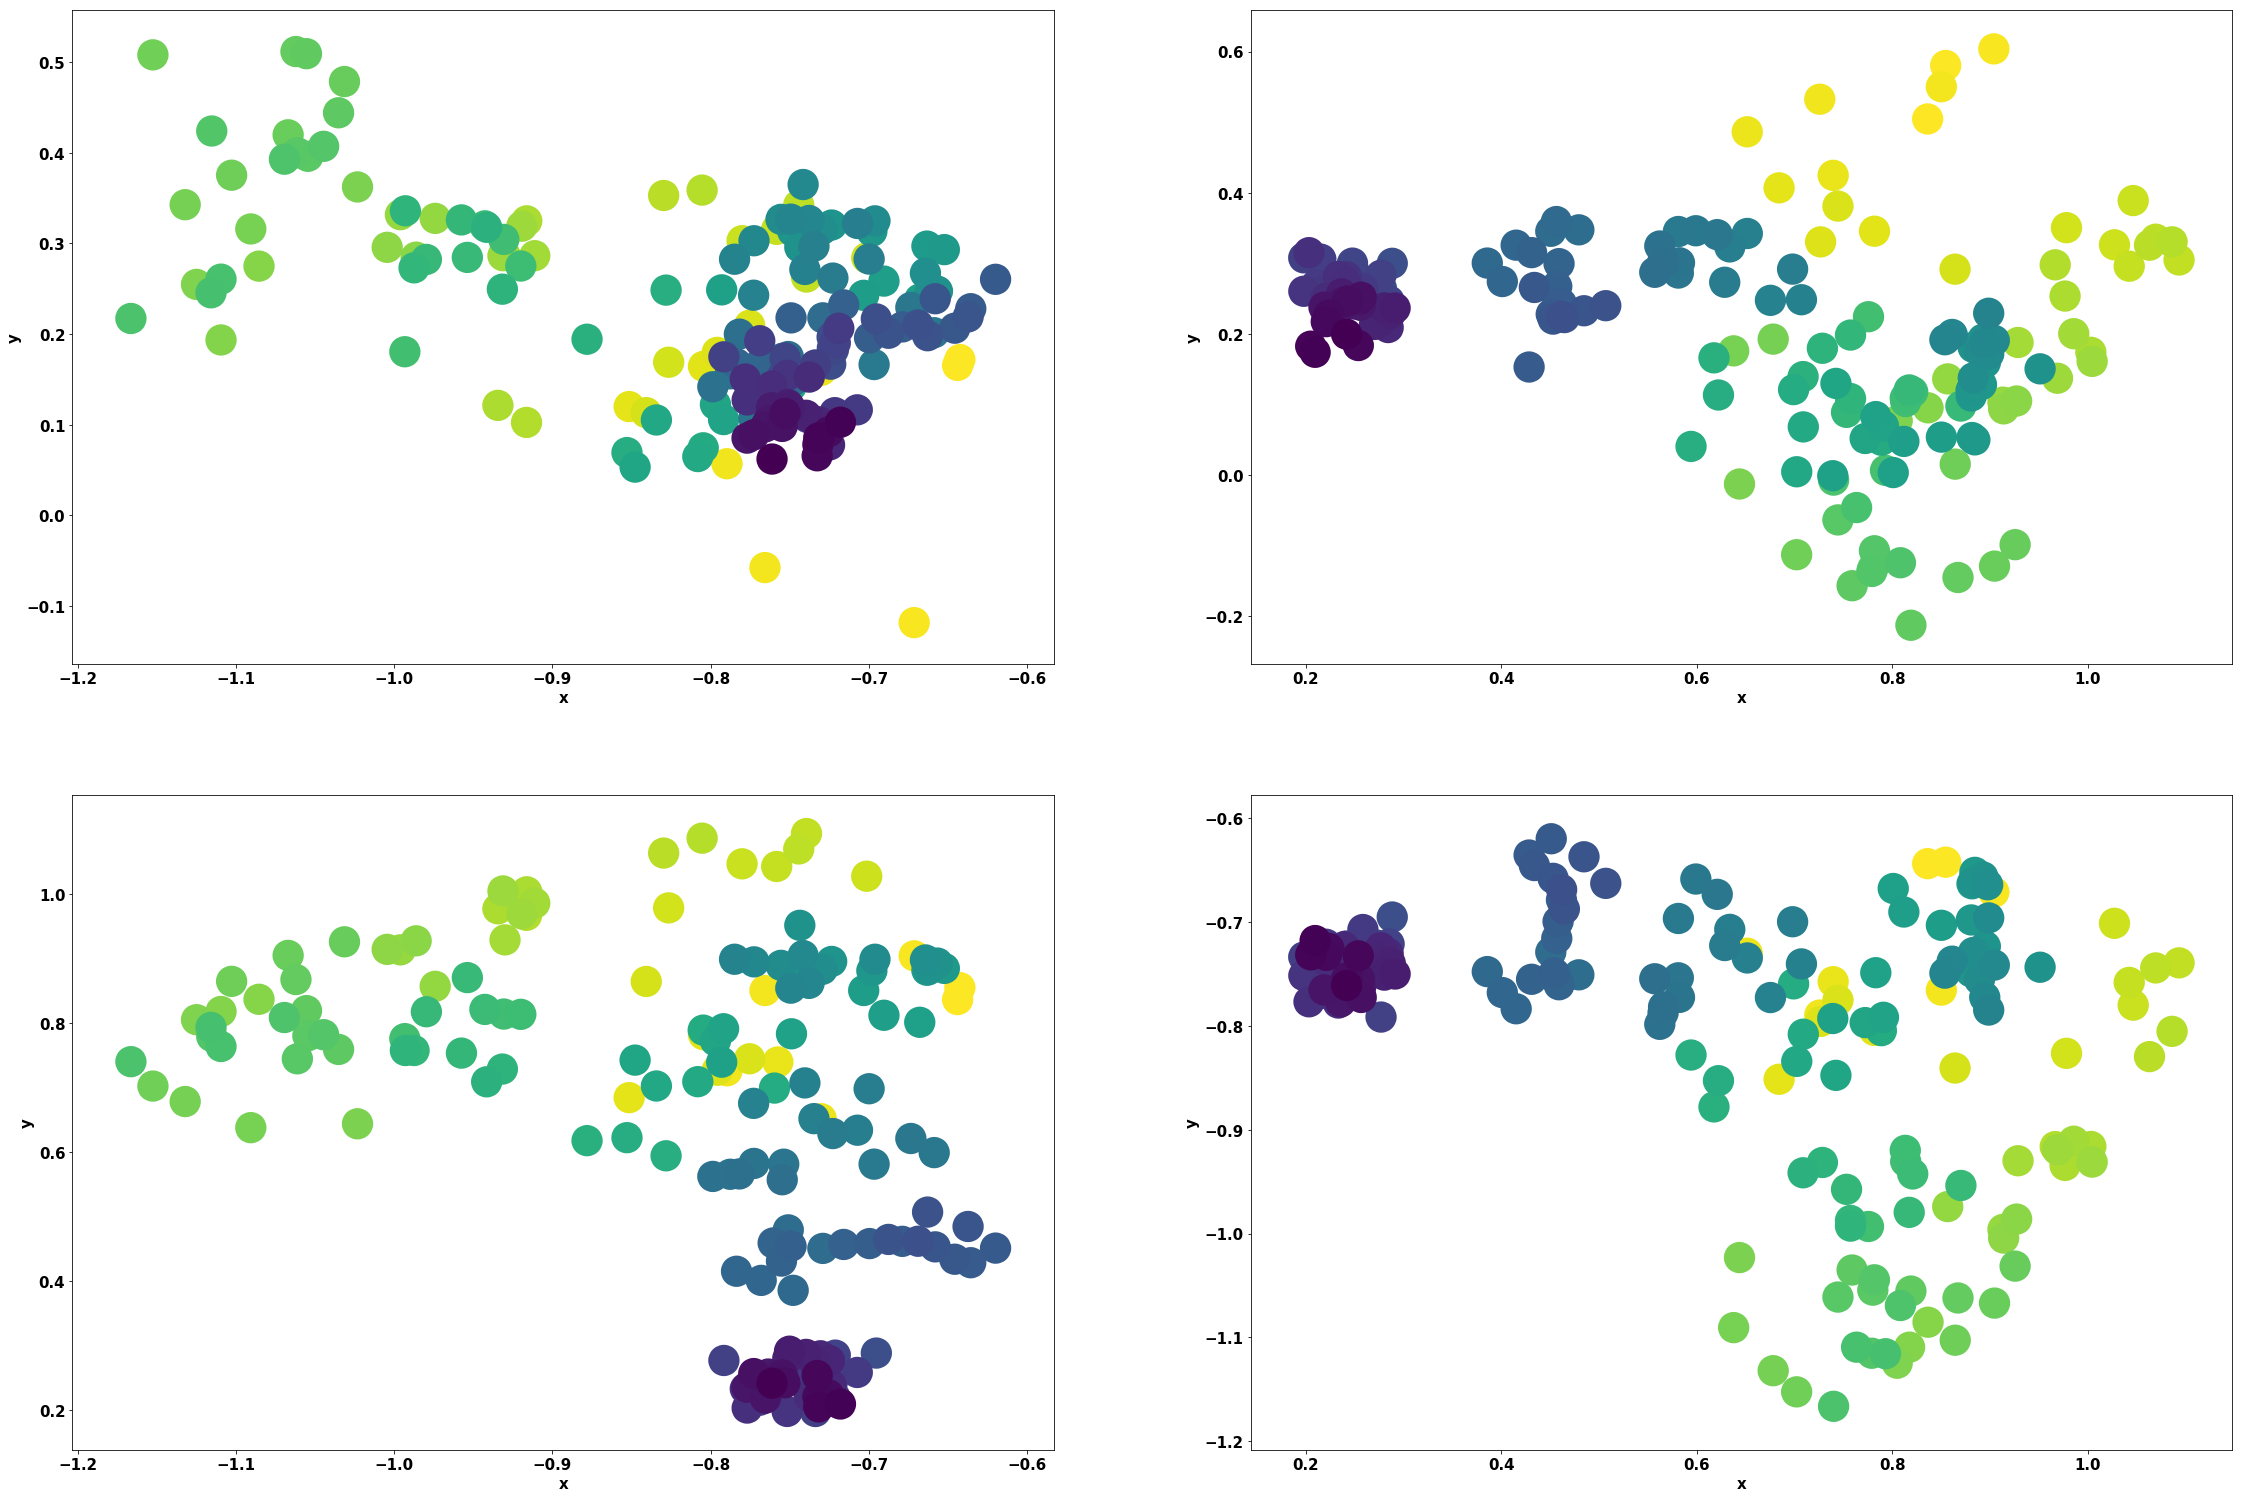

In [144]:
k = 0
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0,right =5,bottom = 0, top=5)

for m in mlist:
    ax = axs[k//2, k%2]
    k = k+1
    ax.set_autoscale_on(True)
    ax.set_ylabel('y',fontdict=font)
    ax.set_xlabel('x',fontdict=font)
    ax.scatter(means[:,(k*k+2)%4],means[:,(k+4)%5],300,c = -np.asarray([i for i in range(means.shape[0])]),linewidth=14)  
plt.show()


"Жирность" точки отражает количество объектов выборки

## Вывод
Можно заключить, что при увелении объёма выборки, серднее векторов параметров устанавливается.

# Задание D
## Распланировать базовый вычислительный эксперимент, построить синтетическую выборку
1. Основная цель эксперимента: создание и теоретическое обоснование методов оценки объема многофакторных выборок, учитывающих вид модели классификации и более точных по сравнению с известными методами; создание методов классификации малых выборок.
2. Синтетическая выборка:
    1. Данные вручную сгенерированы так, чтобы на них можно было протестировать работу алгоритмов классификации.
    2. Размер синтетических данных соответсвует размеру исходных данных.


### Синтетические данные для тестов

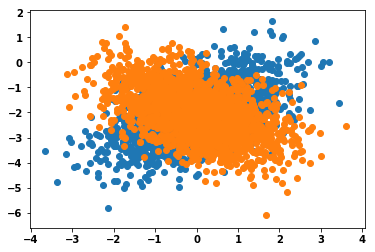

In [35]:
X=[]
for i in range(2):
    max_size = 2*1000
    m_1 = [0,-2]
    m_2 = [0,-2]
    random_state = 1
    a = np.random.multivariate_normal(m_1,np.asarray([[1,0.5],[0.5,1]]), max_size)
    b = np.random.multivariate_normal(m_2,np.asarray([[1,-0.5],[-0.5,1]]), max_size)
    X1 = []
    Y1 = []
    data = np.hstack([a,b]).reshape(-1,2)
    for i in data:
        X1.append(i)
        Y1.append(int(i in a))
    X1 = np.asarray(X1)
    Y1 = np.asarray(Y1)
    X.append(np.hstack([X1, Y1.reshape(-1,1)]))
Xtrain =X[0]
Xtest = X[1]
X = Xtrain[:,:-1]
y = Xtrain[:,-1]
X_t = Xtest[:,:-1]
y_t = Xtest[:,-1]
plt.scatter(a[:,0],a[:,1])
plt.scatter(b[:,0],b[:,1])

In [150]:
from scipy.optimize import curve_fit


In [151]:
curve_fit(inv_pow, x, divergence[1:])

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(array([ 5.11350047, 23.19343617]), array([[inf, inf],
        [inf, inf]]))

In [152]:
x = [i+1 for i in range(len(divergence)-1)]

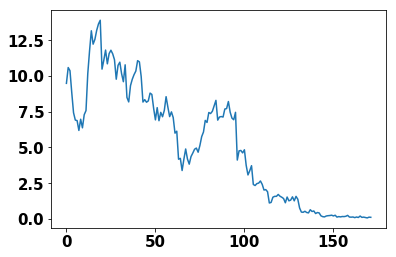

In [153]:
plt.plot(divergence)